In [1]:
from google.colab import drive
drive.mount('/content/drive')
from sklearn.metrics import ndcg_score # метрика
from sklearn.preprocessing import OneHotEncoder # Для query_id
import os,random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.losses import categorical_crossentropy
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout, Dense, Input, concatenate, BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = 'drive/MyDrive/Colab Notebooks/VKintern/'
file_name = 'intern_task.csv'
df = pd.read_csv(path+file_name)
df.keys()

Index(['rank', 'query_id', 'feature_0', 'feature_1', 'feature_2', 'feature_3',
       'feature_4', 'feature_5', 'feature_6', 'feature_7',
       ...
       'feature_134', 'feature_135', 'feature_136', 'feature_137',
       'feature_138', 'feature_139', 'feature_140', 'feature_141',
       'feature_142', 'feature_143'],
      dtype='object', length=146)

In [3]:
data = df.values
len(set(data[:,1])) # Количество разных запросов

2000

In [4]:
np.random.shuffle(data) # Перемешивание

In [5]:
# Разделение таблицы на фичи, ранги и id запросов
def divide_info(a):
  return a[:,2:],a[:,0],a[:,1]
x, rank, qi = divide_info(data)
x.shape, rank.shape, qi.shape

((235258, 144), (235258,), (235258,))

Анализ датасета

In [6]:
d = {'0':0,'1':0,'2':0,'3':0,'4':0}
for i in rank:
  d[str(int(i))]+=1
print('Распределение рангов:',d)
d = {str(i):0 for i in set(data[:,1])}
for i in qi:
  d[str(i)]+=1
k=0
for i in d.keys():
  if d[i]<20:
    k+=1
print('Число запросов с количеством наборов фичей меньше 20:',k)

Распределение рангов: {'0': 121521, '1': 75815, '2': 31910, '3': 4209, '4': 1803}
Число запросов с количеством наборов фичей меньше 20: 75


In [7]:
# Ранги и запросы переходят в вид векторов OneHotEncoder
vector = qi.reshape(-1, 1)
encoder = OneHotEncoder(sparse=False)
encoder.fit(vector)
qi = encoder.transform(vector)
vector = rank.reshape(-1,1)
rank = encoder.fit(vector).transform(vector)
print(qi.shape,rank.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(235258, 2000) (235258, 5)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
# Разделение тестовой и тренировочной выборок
# 2000 уникальных запросов повторятся 8 раза среди 16000 запросов тестовой выборки
tx = x[:16000]
tqi = qi[:16000]
trank = rank[:16000]
x = x[16000:]
qi = qi[16000:]
rank = rank[16000:]
trank.shape, rank.shape # Размеры выборок

((16000, 5), (219258, 5))

In [16]:
In_query = Input((2000,))
In_features = Input((144,))
features = Dense(1024,activation='sigmoid')(In_features)
features = BatchNormalization()(features)
features = Dense(32,activation='relu')(features)
query = Dense(16,activation='relu')(In_query)
fin = concatenate([features,query])
fin = Dense(32,activation='relu')(fin)
fin = Dense(5,activation='softmax')(fin)
model = Model([In_query,In_features],fin)
model.compile(loss='categorical_crossentropy',optimizer=Adam(0.0003),metrics=[tf.keras.metrics.Precision(),tf.keras.metrics.F1Score()])
print('Число параметров:',
      sum([np.array(i).reshape(-1).shape[0] for i in model.weights]))

Число параметров: 219125


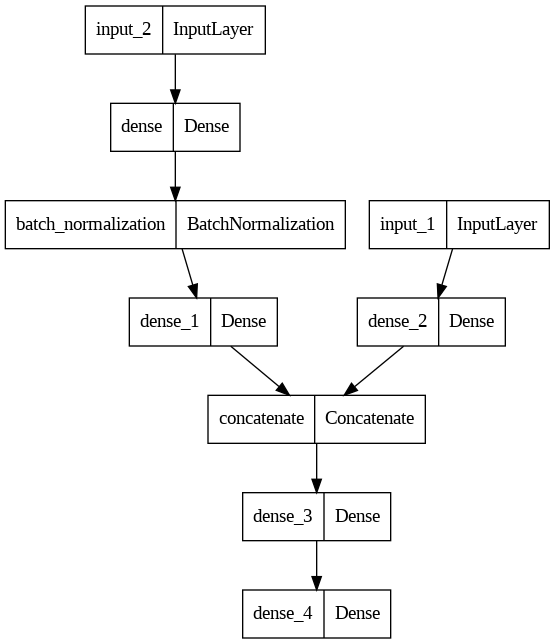

In [10]:
utils.plot_model(model)

In [17]:
h = model.fit([qi,x],rank,
              batch_size=16000,     # Батч порядка количества запросов
              epochs = 40,
              validation_split=0.1) # Тренировка с валидационной выборкой

Epoch 1/40
13/13 [==============================] - 5s 191ms/step - loss: 1.4663 - precision_1: 0.3059 - f1_score: 0.1800 - val_loss: 1.2363 - val_precision_1: 0.5152 - val_f1_score: 0.1423
Epoch 2/40
13/13 [==============================] - 2s 132ms/step - loss: 1.2139 - precision_1: 0.5337 - f1_score: 0.1606 - val_loss: 1.5458 - val_precision_1: 0.5172 - val_f1_score: 0.1409
Epoch 3/40
13/13 [==============================] - 1s 117ms/step - loss: 1.1296 - precision_1: 0.5383 - f1_score: 0.1461 - val_loss: 1.5034 - val_precision_1: 0.5166 - val_f1_score: 0.1403
Epoch 4/40
13/13 [==============================] - 2s 171ms/step - loss: 1.1034 - precision_1: 0.5388 - f1_score: 0.1417 - val_loss: 1.4183 - val_precision_1: 0.5163 - val_f1_score: 0.1415
Epoch 5/40
13/13 [==============================] - 2s 176ms/step - loss: 1.0944 - precision_1: 0.5432 - f1_score: 0.1417 - val_loss: 1.4477 - val_precision_1: 0.5163 - val_f1_score: 0.1405
Epoch 6/40
13/13 [==============================] 

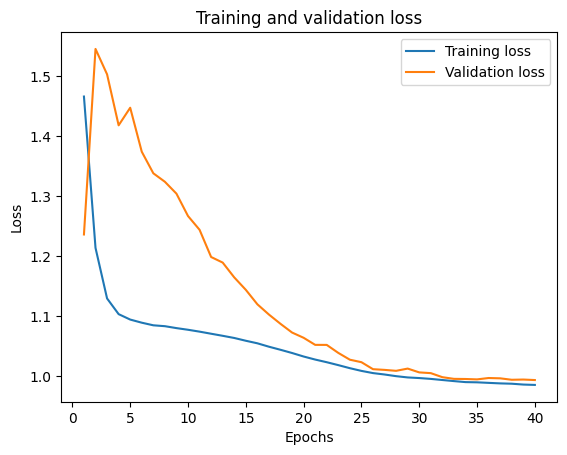

In [18]:
# Визуализация процесса обучения
history_dict = h.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, label='Training loss')
plt.plot(epochs, val_loss_values, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
p = model.predict([tqi,tx])  # Предсказание тестовой выборки

500/500 [==============================] - 1s 2ms/step


In [20]:
# Расчет матрики ndcg_5b на тестовой выборке
y_true = trank
y_score = p
score = ndcg_score(y_true, y_score, k=5)
print(np.round(score*10000)/100,'%')

81.46 %


In [15]:
# Ранжирование модели ndcg5
for i in p:
  for k,j in enumerate(i):
    if j==max(i):
      i[k] = 1.
p = np.round(p)
z = random.randint(1,len(trank))
print('Prediction   ',*p[z:z+10])
print('Original rank',*rank[z:z+10])

Prediction    [0. 1. 0. 0. 0.] [1. 0. 0. 0. 0.] [0. 1. 0. 0. 0.] [0. 1. 0. 0. 0.] [0. 1. 0. 0. 0.] [1. 0. 0. 0. 0.] [0. 1. 0. 0. 0.] [1. 0. 0. 0. 0.] [1. 0. 0. 0. 0.] [1. 0. 0. 0. 0.]
Original rank [1. 0. 0. 0. 0.] [1. 0. 0. 0. 0.] [1. 0. 0. 0. 0.] [1. 0. 0. 0. 0.] [1. 0. 0. 0. 0.] [0. 0. 1. 0. 0.] [1. 0. 0. 0. 0.] [1. 0. 0. 0. 0.] [0. 1. 0. 0. 0.] [0. 1. 0. 0. 0.]
